In [1]:
import json
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("ggplot")

# Load Data

In [2]:
path_db = pathlib.Path() / ".." / "db"
path_assets = pathlib.Path() / "assets"
path_parquet = path_db / "20221107-20221205" / "20221107.parquet"

In [3]:
cards = {}
with open(path_assets / "cards.json") as f:
    for i, card in enumerate(json.load(f)):
        cards[i] = {**card, "img": path_assets / "cards" / f"{card['key']}.png"}


# read parquet file with different comluns order.
# Having team/opponent alternated columns allow to store
# similar data in countinuous chunk of memory
# (e.g. cards from team and opponent decks are store at [:, -256:]
# so it easier to manipulate them without create new arrays).

columns = [
    "('info', 'datetime')",
    "('info', 'game_mode')",
    "('team', 'tag')",
    "('opponent', 'tag')",
    "('team', 'trophies')",
    "('opponent', 'trophies')",
    "('team', 'crowns')",
    "('opponent', 'crowns')",
    *[f"('team', 'c{i}')" for i in np.arange(128)],
    *[f"('opponent', 'c{i}')" for i in np.arange(128)],
]

battles = pd.read_parquet(path_parquet, engine="pyarrow", columns=columns)

decks = battles.iloc[:, -256:].values  # decks as np.array
decks = decks.reshape((decks.shape[0] * 2, decks.shape[1] // 2))  # join decks
decks = decks[:, : len(cards)]  # remove empty cards

# Analysis

## Card Usage 

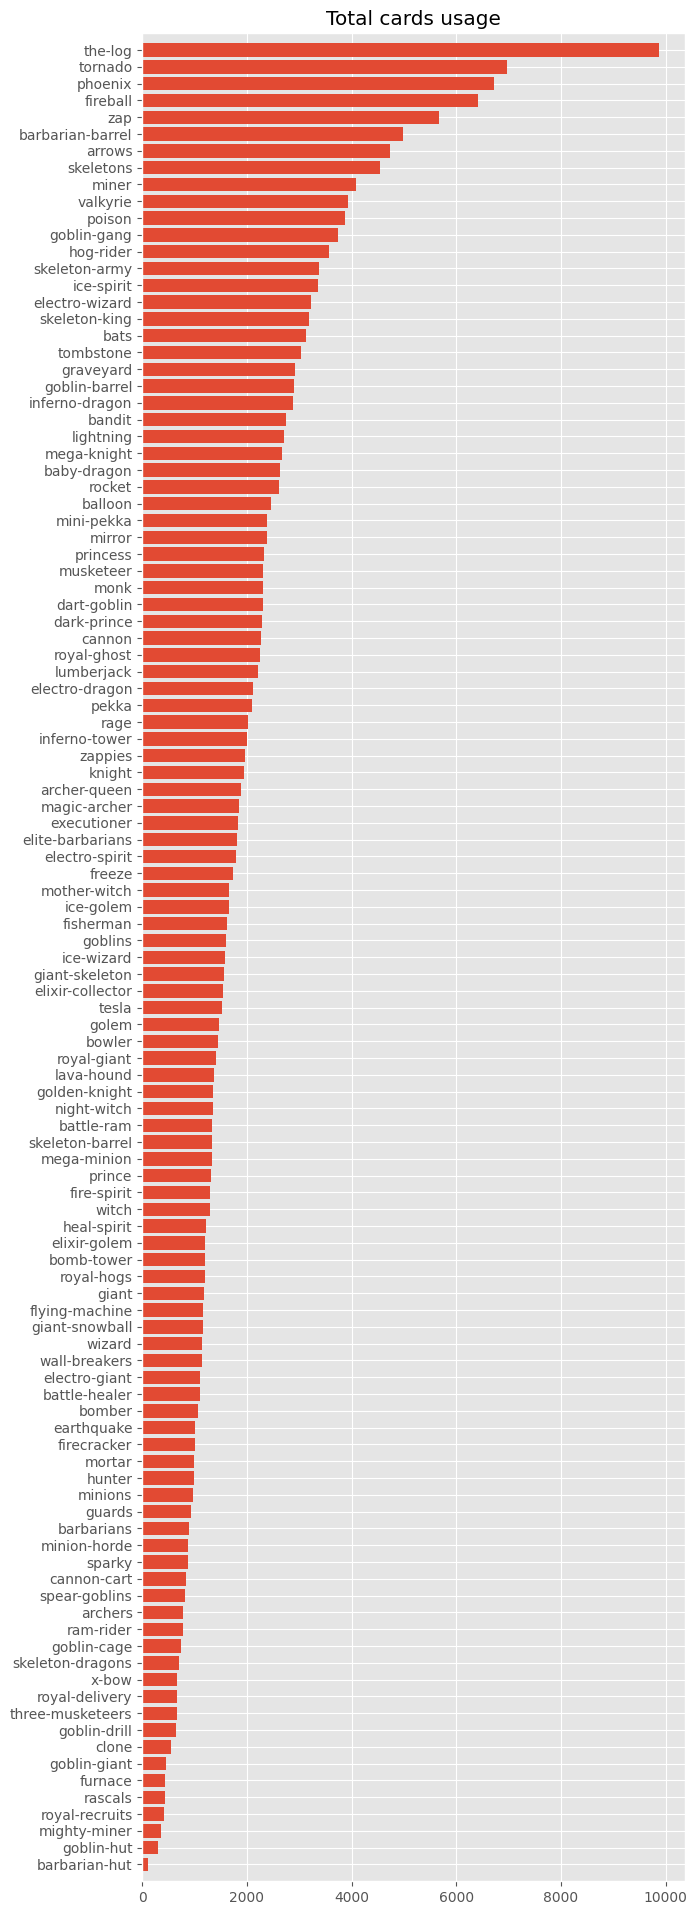

In [4]:
cards_usage = decks.sum(axis=0)
cards_usage_sorted = np.argsort(cards_usage)

fig, ax = plt.subplots(figsize=(7, 24))

ax.barh(
    np.arange(len(cards)),
    cards_usage[cards_usage_sorted],
    align="center",
    tick_label=[cards[i]["key"] for i in cards_usage_sorted],
)
ax.set_ylim(ymin=-1, ymax=len(cards))
ax.set_title("Total cards usage");